In [ ]:
import os
import time
import numpy as np
import pandas as pd
import cv2
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D , BatchNormalization ,Activation
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.inception_v3 import InceptionV3



In [ ]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:

IMG_SIZE = 224
NUM_CLASSES = 10
DATASET_PATH = "/content/drive/MyDrive/raw-img"

In [ ]:

classes = sorted(os.listdir(DATASET_PATH))
print("Classes found:", classes)


Classes found: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


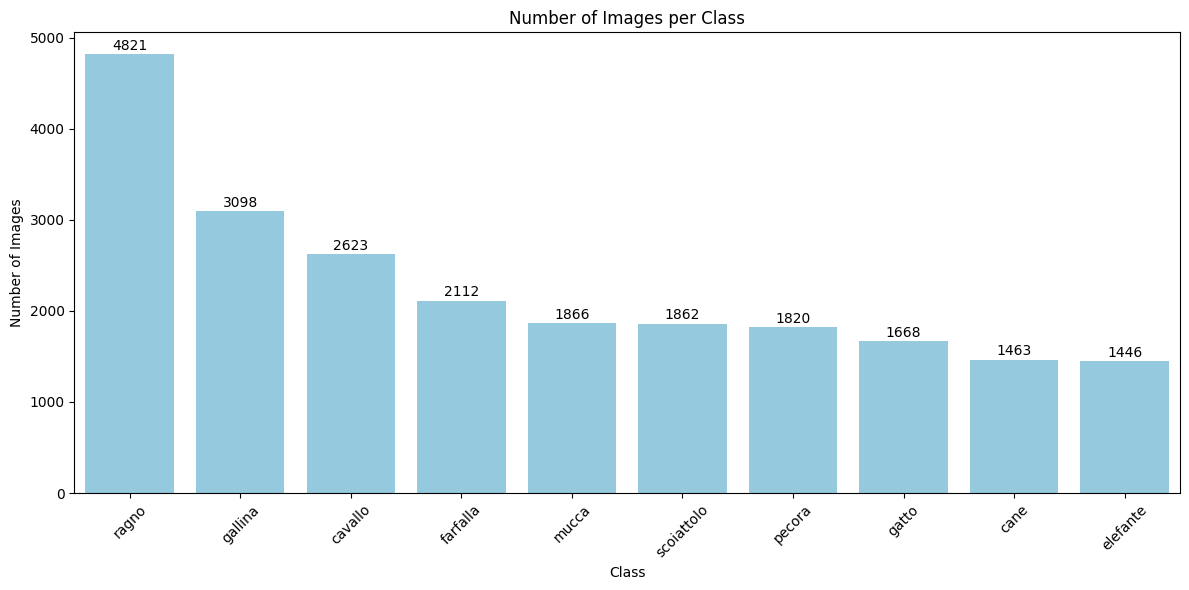

In [ ]:

image_count = {}
valid_extensions = ('.jpg', '.jpeg', '.png')

for class_name in os.listdir(DATASET_PATH):
    class_path = os.path.join(DATASET_PATH, class_name)
    if os.path.isdir(class_path):
        count = len([file for file in os.listdir(class_path)
                     if file.lower().endswith(valid_extensions)])
        image_count[class_name.lower()] = count  # Lowercase standardization

# Convert to DataFrame and sort
df_counts = pd.DataFrame(list(image_count.items()), columns=['Class', 'Image Count'])
df_counts = df_counts.sort_values(by='Image Count', ascending=False).reset_index(drop=True)

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='Class', y='Image Count', data=df_counts, color='skyblue')

# Add labels above bars
for i, row in df_counts.iterrows():
    plt.text(i, row['Image Count'] + 50, str(row['Image Count']), ha='center', fontsize=10)

plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()

# Save the figure
plt.savefig("image_distribution_updated.png")
plt.show()


In [ ]:

def load_dataset(path, img_size):
    X = []
    y = []
    class_names = sorted(os.listdir(path))
    class_map = {class_name: idx for idx, class_name in enumerate(class_names)}

    for class_name in class_names:
        class_path = os.path.join(path, class_name)
        for img_path in glob(os.path.join(class_path, '*.jpg')):
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (img_size, img_size))
                X.append(img)
                y.append(class_map[class_name])

    X = np.array(X, dtype=np.float32) / 255.0
    y = to_categorical(y, num_classes=len(class_names))
    return train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
X_train, X_test, y_train, y_test = load_dataset(DATASET_PATH,IMG_SIZE)


In [ ]:

# ZFNet
def build_zfnet():
    model = Sequential([
        Conv2D(96, (7, 7), strides=(2, 2), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        Conv2D(256, (5, 5), activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        Conv2D(384, (3, 3), activation='relu'),
        Conv2D(384, (3, 3), activation='relu'),
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(3, 3), strides=(2, 2)),
        Flatten(),
        Dense(4096, activation='relu'),
        Dropout(0.5),
        Dense(NUM_CLASSES, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:

# VGG16
def build_vgg16():
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    for layer in base_model.layers:
        layer.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:

# GoogLeNet (InceptionV3)
def build_inception():
    base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
    for layer in base_model.layers:
        layer.trainable = False
    x = GlobalAveragePooling2D()(base_model.output)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(NUM_CLASSES, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=predictions)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
def plot_accuracy_loss(history, model_name):
    import matplotlib.pyplot as plt

    plt.figure(figsize=(12, 5))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title(f'{model_name} - Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title(f'{model_name} - Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


In [ ]:
def train_model(name, model):
    print(f"\nTraining {name}...")
    start = time.time()
    history = model.fit(X_train, y_train, epochs=5, validation_split=0.2, batch_size=32)
    end = time.time()

    # Evaluate model
    loss, acc = model.evaluate(X_test, y_test)
    print(f"{name} Accuracy: {acc:.4f}, Time: {end - start:.2f}s")

    # Plot overfitting graph
    plot_accuracy_loss(history, name)

    return history, acc, end - start

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Training ZFNet...
Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 27s 387ms/step - accuracy: 0.2441 - loss: 4.6100 - val_accuracy: 0.2313 - val_loss: 1.5936
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 21s 110ms/step - accuracy: 0.2531 - loss: 1.5838 - val_accuracy: 0.3453 - val_loss: 1.4945
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 109ms/step - accuracy: 0.3145 - loss: 1.5021 - val_accuracy: 0.3453 - val_loss: 1.4321
Epoch 4/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.3342 - loss: 1.4477 - val_accuracy: 0.3974 - val_loss: 1.3802
Epoch 5/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.3902 - loss: 1.3993 - val_accuracy: 0.3355 - val_loss: 1.4261
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2807 - loss: 1.4555
ZFNet Accuracy: 0.2760, Time: 63.27s


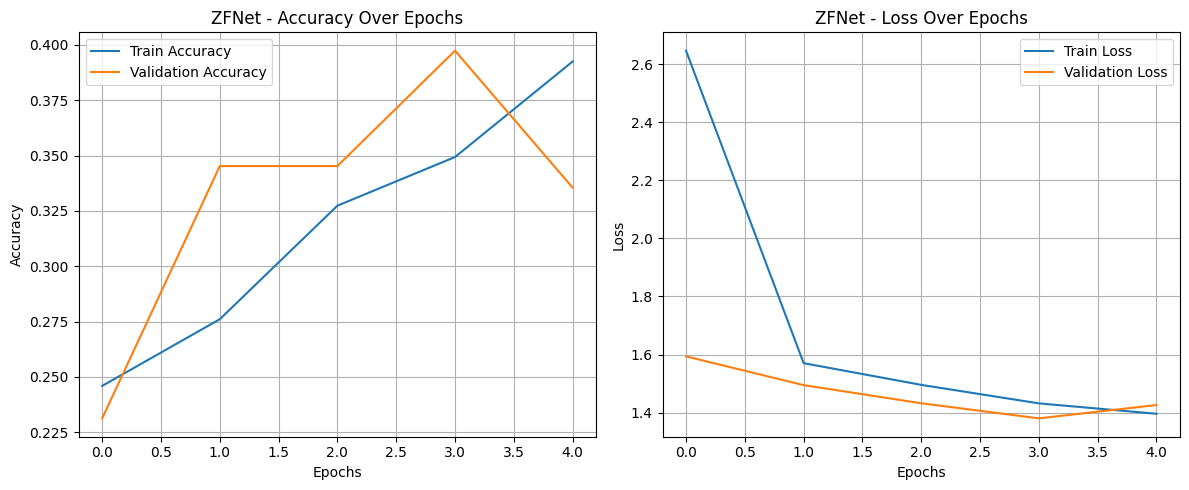

In [ ]:
# Build and train ZFNet

zfnet = build_zfnet()
history_zfnet, acc_zfnet, time_zfnet = train_model("ZFNet", zfnet)

# Store results
results = {}
results["ZFNet"] = {
    "history": history_zfnet,
    "acc": acc_zfnet,
    "time": time_zfnet
}


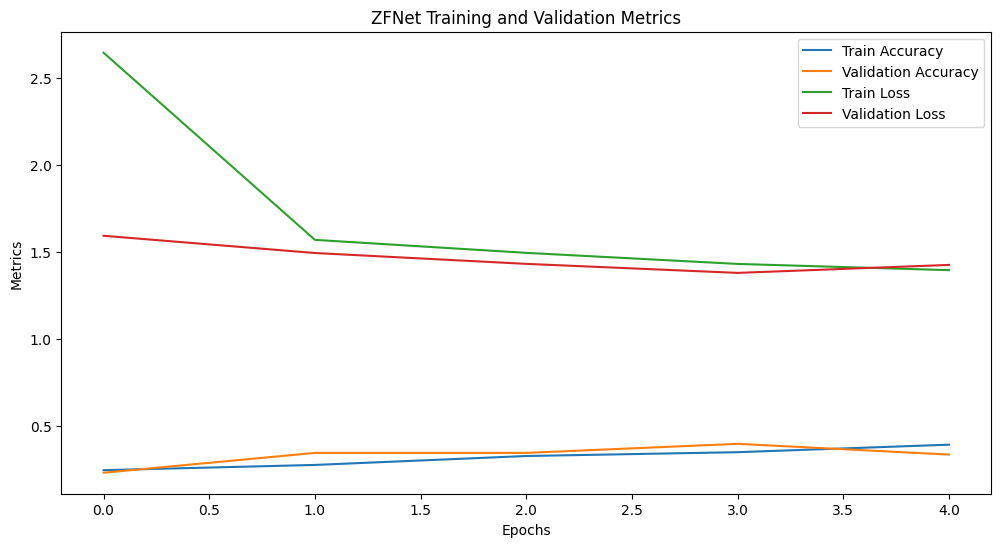

In [ ]:
import matplotlib.pyplot as plt
history = results['ZFNet']['history']

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('ZFNet Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step

Training VGG16...
Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 34s 583ms/step - accuracy: 0.4071 - loss: 1.5848 - val_accuracy: 0.7785 - val_loss: 0.7155
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 17s 220ms/step - accuracy: 0.7188 - loss: 0.7365 - val_accuracy: 0.8274 - val_loss: 0.5195
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 191ms/step - accuracy: 0.8043 - loss: 0.5489 - val_accuracy: 0.8371 - val_loss: 0.4586
Epoch 4/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 11s 219ms/step - accuracy: 0.8671 - loss: 0.4455 - val_accuracy: 0.8762 - val_loss: 0.4088
Epoch 5/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 10s 220ms/step - accuracy: 0.8961 - loss: 0.3537 - val_accuracy: 0.8925 - val_loss: 0.3612
12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 157ms/step - accuracy: 0.8630 - loss: 0.3857
VGG16 Accuracy: 0.8932, Time: 81.66s


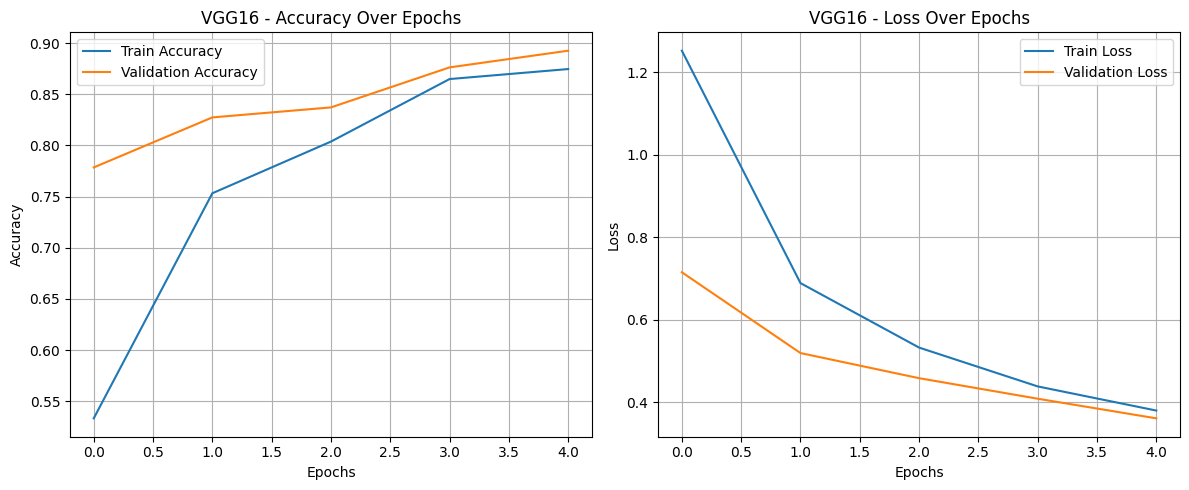

In [ ]:
# Build and train VGG16
vgg16 = build_vgg16()
history_vgg16, acc_vgg16, time_vgg16 = train_model("VGG16", vgg16)

# Store results
results["VGG16"] = {
    "history": history_vgg16,
    "acc": acc_vgg16,
    "time": time_vgg16
}


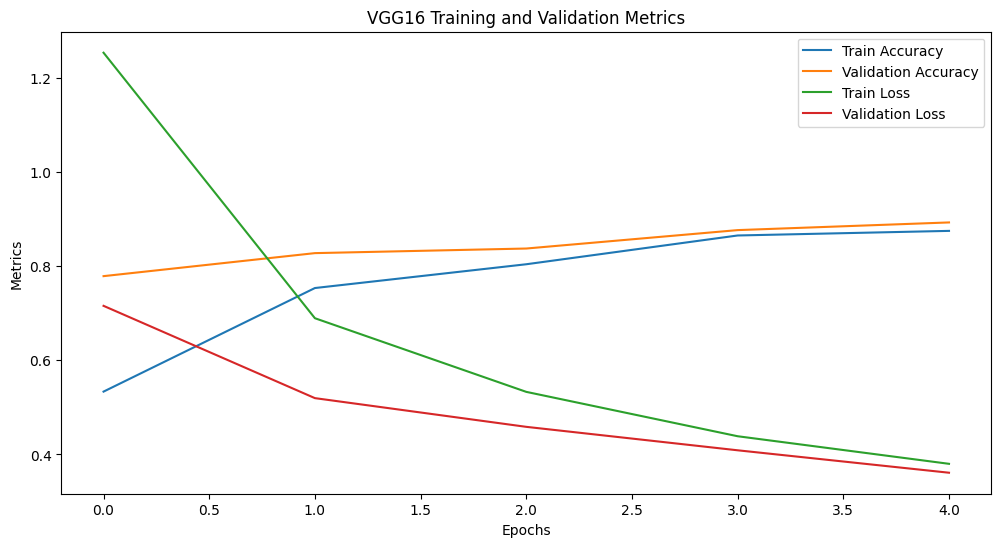

In [ ]:
history = results['VGG16']['history']

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('VGG16 Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()



Training GoogLeNet...
Epoch 1/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 33s 540ms/step - accuracy: 0.7452 - loss: 0.8556 - val_accuracy: 0.9544 - val_loss: 0.1669
Epoch 2/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 18s 79ms/step - accuracy: 0.9615 - loss: 0.1285 - val_accuracy: 0.9674 - val_loss: 0.0981
Epoch 3/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.9717 - loss: 0.0889 - val_accuracy: 0.9772 - val_loss: 0.1131
Epoch 4/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - accuracy: 0.9864 - loss: 0.0432 - val_accuracy: 0.9674 - val_loss: 0.1181
Epoch 5/5
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.9856 - loss: 0.0377 - val_accuracy: 0.9577 - val_loss: 0.1594
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.9685 - loss: 0.1058
GoogLeNet Accuracy: 0.9661, Time: 67.02s


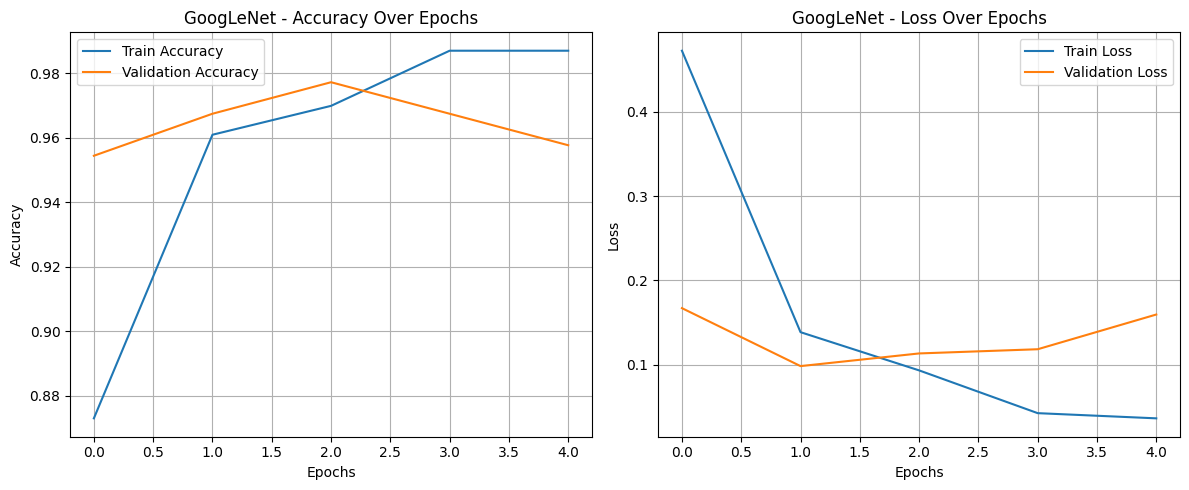

In [ ]:
# Build and train GoogLeNet (InceptionV3)
googlenet = build_inception()
history_googlenet, acc_googlenet, time_googlenet = train_model("GoogLeNet", googlenet)

# Store results
results["GoogLeNet"] = {
    "history": history_googlenet,
    "acc": acc_googlenet,
    "time": time_googlenet
}


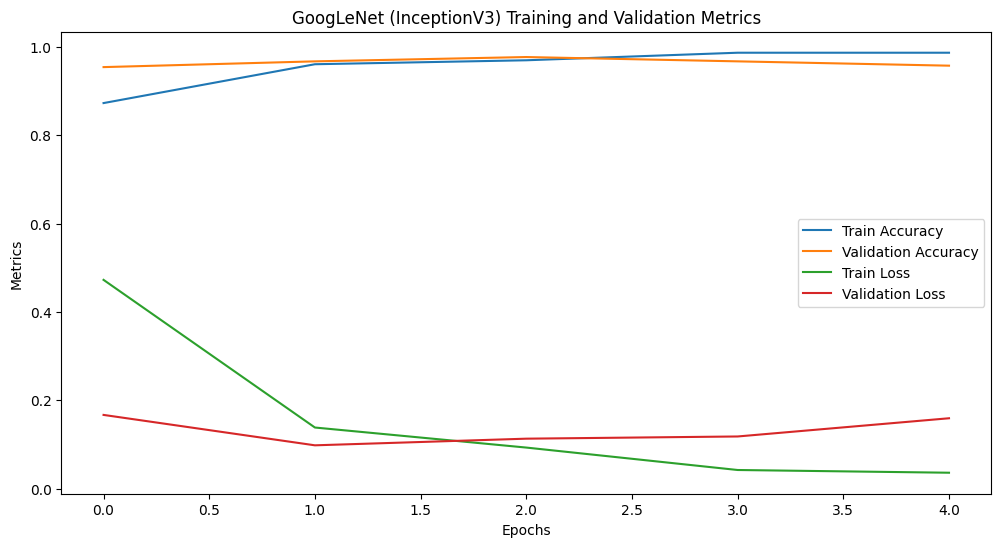

In [ ]:
history = results['GoogLeNet']['history']

plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('GoogLeNet (InceptionV3) Training and Validation Metrics')
plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.legend()
plt.show()


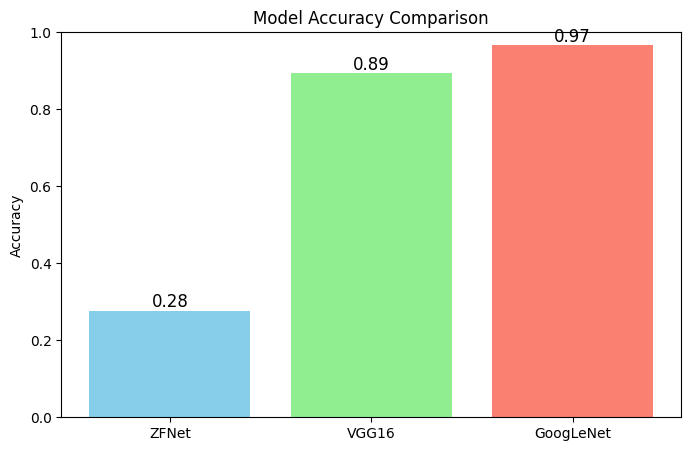

In [ ]:
# Bar chart to compare accuracy
model_names = list(results.keys())
accuracies = [results[name]['acc'] for name in model_names]

plt.figure(figsize=(8, 5))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylim(0, 1)
plt.ylabel('Accuracy')
plt.title('Model Accuracy Comparison')

# Add value labels on top
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height + 0.01, f'{height:.2f}', ha='center', fontsize=12)

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Predicted: elefante (100.00%)


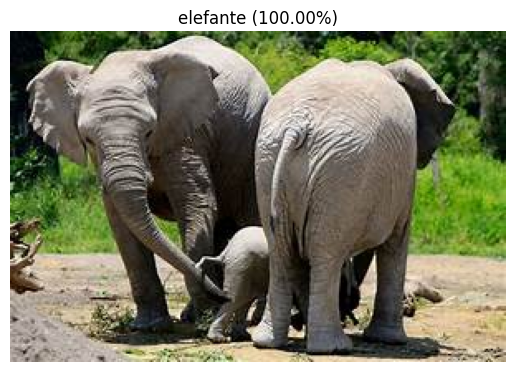

In [ ]:
# Function to predict and show the class of a single image
def predict_image(image_path, model, class_names):
    img = cv2.imread(image_path)
    if img is None:
        print("Error loading image.")
        return
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
    img = img.astype("float32") / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension

    prediction = model.predict(img)[0]
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction)

    print(f"Predicted: {predicted_class} ({confidence * 100:.2f}%)")

    # Show the image with predicted label
    import matplotlib.pyplot as plt
    plt.imshow(cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB))
    plt.title(f"{predicted_class} ({confidence * 100:.2f}%)")
    plt.axis('off')
    plt.show()
# Get class names (same order used in training)
class_names = sorted(os.listdir(DATASET_PATH))

# Predict on a new image
test_image_path = "/content/drive/MyDrive/raw-img/elefante/OIP-ZPRJ85QAzQ7hC4vp7vzErwHaE8.jpeg"
predict_image(test_image_path, googlenet, class_names)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Predicted: ragno (100.00%)


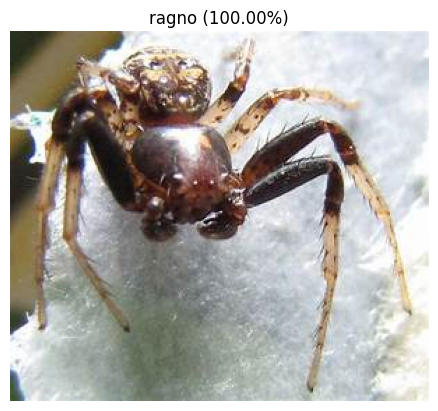

In [ ]:
test_image_path = "/content/drive/MyDrive/raw-img/ragno/OIP-Zy4Kdt2PTcAnCfTsViRJ7wHaGi.jpeg"
predict_image(test_image_path, googlenet, class_names)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
Predicted: gatto (99.66%)


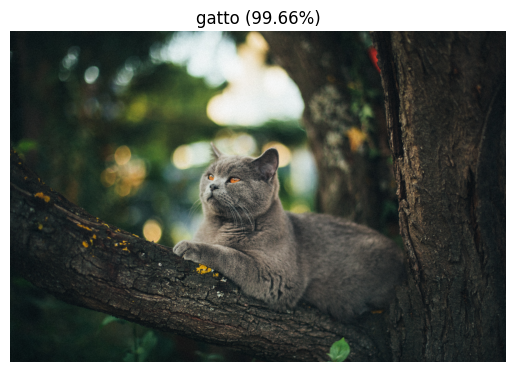

In [ ]:
test_image_path = "/content/drive/MyDrive/raw-img/gatto/max-boettinger-486490-unsplash.jpg"
predict_image(test_image_path, googlenet, class_names)

In [ ]:
test_image_path = "/content/drive/MyDrive/raw-img/scoiattoll/OIP-ZzV2cnnarfBv1b0Xj7cvMwHaEX.jpeg"
predict_image(test_image_path, googlenet, class_names)

Error loading image.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Predicted: farfalla (100.00%)


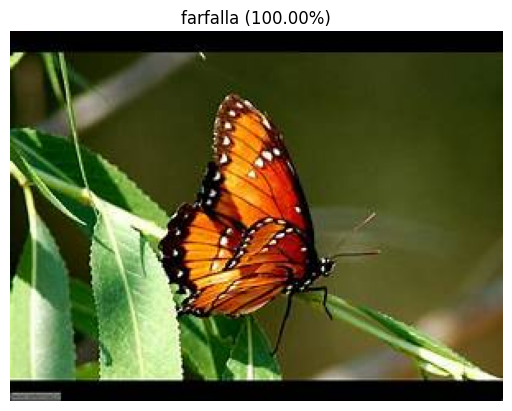

In [ ]:
test_image_path = "/content/drive/MyDrive/raw-img/farfalla/OIP-ZunYgEud0RqEjpnoLjtoXQHaFj.jpeg"
predict_image(test_image_path, googlenet, class_names)



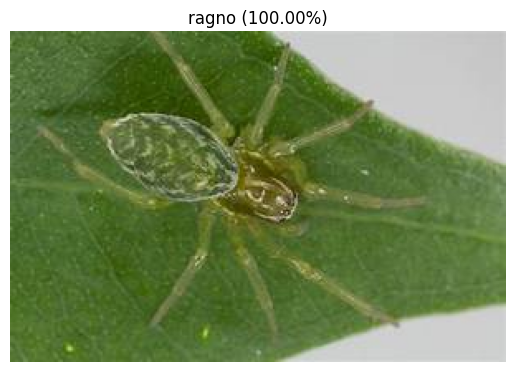

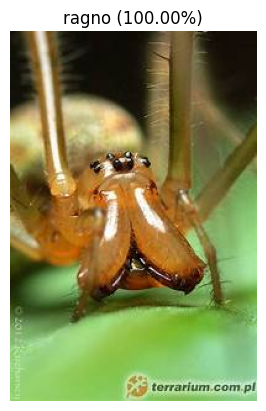

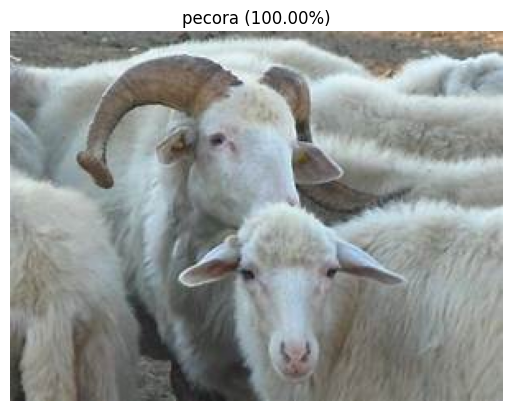

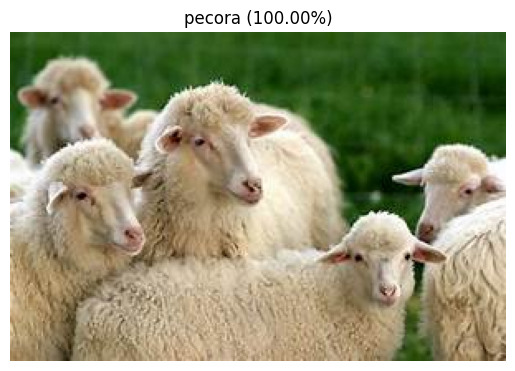

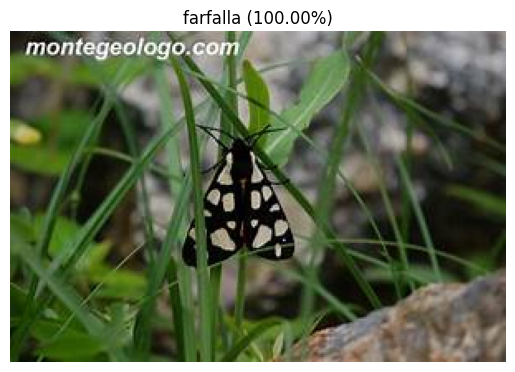

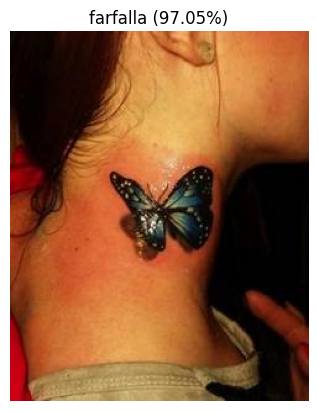

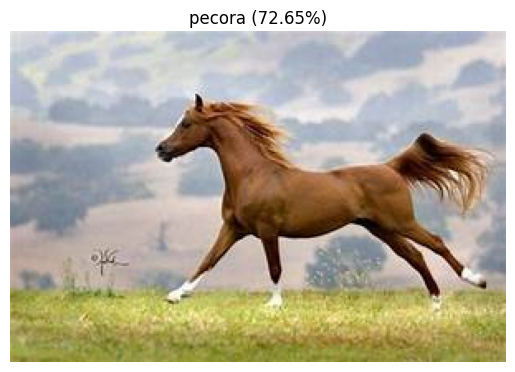

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array

def predict_multiple_images(image_folder, model, class_names, img_size=224):
    image_paths = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder)
                   if fname.lower().endswith(('.jpg', '.jpeg', '.png'))]

    if not image_paths:
        print("No images found in the folder.")
        return

    images = []
    original_images = []

    for path in image_paths:
        img = cv2.imread(path)
        if img is not None:
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_resized = cv2.resize(img_rgb, (img_size, img_size))
            img_array = img_to_array(img_resized) / 255.0  # Ensure correct dtype and scaling
            images.append(img_array)
            original_images.append(img_rgb)

    images = np.array(images, dtype=np.float32)

    predictions = model.predict(images, verbose=0)

    for i, prediction in enumerate(predictions):
        predicted_class = class_names[np.argmax(prediction)]
        confidence = np.max(prediction) * 100
        plt.imshow(original_images[i])
        plt.title(f"{predicted_class} ({confidence:.2f}%)")
        plt.axis('off')
        plt.show()
class_names = sorted(os.listdir(DATASET_PATH))  # Make sure to exclude system files if any
image_folder = "/content/drive/MyDrive/test-img"
predict_multiple_images(image_folder, googlenet, class_names)
